<a href="https://colab.research.google.com/github/fhergal/Machine-Learning-with-Python/blob/master/ClasificarGrafosGIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red de Isomorfismo de Grafos o *Graph Isomorphism Network* (GIN)
## Trabajando con la expresividad para la clasificación de grafos
No hay que olvidar que las redes neuronales (NN) se utilizan para aproximar funciones, cosa que viene justificada por el **teorema de aproximación universal**. Este establece que una red neuronal realimentada con una sola capa puede aproximar cualquier función suave. Pero claro, esto en el campo de los grafos es un problema más complejo que nos lleva a trabajar en cómo determinar y distinguir la estructura misma del grafo.

Al seleccionar la arquitectura GNN adecuada para un problema en particular, es crucial comprender las características de los datos del gráfico y el resultado deseado.

Si trabajamos a nivel de nodos, cuando utilizamos GNN buscamos las mejores incrustaciones posibles (embeddings) que nos permiten ver si dos nodos son similares o diferentes. Dos nodos serán similares, si sus incrustaciones son similares y esto se calcula utilizando las características del nodo y la de sus conexiones (nodos vecinos). Este es el problema del **Isomorfismo de grafos**.

Weisfeiler y Lehman [1] propusieron un algoritmo para resolver este problema que resultó ser muy eficaz: test WL.

El test WL tiene como objetivo onstruir la forma canónica de un grafo, de forma que comparándolas entre 2 grafos podríamos saber si son isomorfos o no. Eso sí, tiene un defecto y es que se puede dar el caso de que haya 2 grafos no isomórficos que compartan la misma forma canónica. Ahora mismo no hay respuesta para este problema.

Vamos a utilizar este ejemplo con pasos parecidos a los de las GNN básicas pero utilizando colores como forma de incrustación, y la función hash será un agregador haciendo uso de la función hash.

Basándones en que el test WL mide mejor la expresividad de los grafos, y teniendo en cuenta que la capacidad de distinguir estructuras gráficas está muy relacionado con la calidad de las incrustaciones aparece una nueva arquitectura
*Graph Isomorphism Network* (GIN) fundamentada en esta idea.

Introducido en 2018 por Xu et al. en un artículo titulado "¿Cómo de potentes son las redes Neuronales de Grafo?", la GIN está diseñada para ser igual de expresiva que el test WL. Los autores generalizaron la agregación dividiéndola en dos funciones:

1.   Agregación: La función **f** selecciona los nodos vecinos que considera la GNN
2.   Combinación: La función **ϕ** combina las incrustaciones de esos nodos seleccionados y genera una nueva incrustación del nodo destino.

Todo quedaría de la siguiente forma:

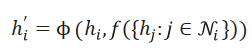




**Comparar con GCN/GAT/MLP**

In [1]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 \
torch-spline-conv~=1.2.1 torch-geometric==2.2.0 \
-f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(11)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


Conjunto de datos TUDataset:
https://huggingface.co/datasets/graphs-datasets/PROTEINS

```
# Tiene formato de código
```




In [2]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='.', name='PROTEINS').shuffle()

# Pintamos la información del dataset
print(f'Dataset: {dataset}')
print('-----------------------')
print(f'Número de grafos: {len(dataset)}')
print(f'Número de nodos: {dataset[0].x.shape[0]}')
print(f'Número de características: {dataset.num_features}')
print(f'Número de clases: {dataset.num_classes}')

Extracting ./PROTEINS/PROTEINS.zip
Processing...


Dataset: PROTEINS(1113)
-----------------------
Número de grafos: 1113
Número de nodos: 14
Número de características: 3
Número de clases: 2


Done!


In [3]:
from torch_geometric.loader import DataLoader

# Dividimos los datos (grafos) en conjuntos de entrenamiento (train),
# validación (validation), y test con una división de 80/10/10 respectivamente:
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Conjunto de entrenamiento = {len(train_dataset)} grafos')
print(f'Conjunto de validación    = {len(val_dataset)} grafos')
print(f'Conjunto de test          = {len(test_dataset)} grafos')

# Creamos mini-batches de tamaño 64 (1 batch = 64 grafos)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=True)

print('\nCargador de Entrenamiento:')
for i, batch in enumerate(train_loader):
    print(f' - Batch {i}: {batch}')
print('\nCargador de Validación:')
for i, batch in enumerate(val_loader):
    print(f' - Batch {i}: {batch}')
print('\nCargador de Test:')
for i, batch in enumerate(test_loader):
    print(f' - Batch {i}: {batch}')

Conjunto de entrenamiento = 890 grafos
Conjunto de validación    = 111 grafos
Conjunto de test          = 112 grafos

Cargador de Entrenamiento:
 - Batch 0: DataBatch(edge_index=[2, 9274], x=[2468, 3], y=[64], batch=[2468], ptr=[65])
 - Batch 1: DataBatch(edge_index=[2, 8972], x=[2366, 3], y=[64], batch=[2366], ptr=[65])
 - Batch 2: DataBatch(edge_index=[2, 8820], x=[2350, 3], y=[64], batch=[2350], ptr=[65])
 - Batch 3: DataBatch(edge_index=[2, 9596], x=[2570, 3], y=[64], batch=[2570], ptr=[65])
 - Batch 4: DataBatch(edge_index=[2, 9108], x=[2490, 3], y=[64], batch=[2490], ptr=[65])
 - Batch 5: DataBatch(edge_index=[2, 10022], x=[2637, 3], y=[64], batch=[2637], ptr=[65])
 - Batch 6: DataBatch(edge_index=[2, 9732], x=[2726, 3], y=[64], batch=[2726], ptr=[65])
 - Batch 7: DataBatch(edge_index=[2, 9316], x=[2533, 3], y=[64], batch=[2533], ptr=[65])
 - Batch 8: DataBatch(edge_index=[2, 7994], x=[2074, 3], y=[64], batch=[2074], ptr=[65])
 - Batch 9: DataBatch(edge_index=[2, 11984], x=[3267,

Compararemos una red GCN y una GIN.

EL modelo **GIN** a utilizar tendrá la siguiente estructura:

> Linear --> BatchNorm --> ReLU --> Linear --> ReLU


- Necesitamos un MLP con al menos dos capas (los autores destacan que el MLP debe tener 2 capas como mínimo).
- Además, según los autores, podemos introducir la normalización por lotes lo que permite estandarizar las entradas de cada capa oculta (para estabilizar y acelerar el entrenamiento sin apenas impacto).
- Usaremos **global_add_pool** para conseguir la incrustación del grafo sumando la incrustación de cada uno de los nodos del grafo.

¡¡¡IMPORTANTE: Trabajar posibilidades de la capa GINE que permite PyTorch
Geometric para incluir características de aristas (edges) en caso de que el dataset lo permite (en este caso PROTEINS no tiene)

In [5]:
import torch
torch.manual_seed(0)
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool


class GCN(torch.nn.Module):
    """GCN"""
    def __init__(self, dim_h):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = Linear(dim_h, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Incrustación del Nodo - Node embeddings
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Lectura a nivel de Grafos
        hG = global_mean_pool(h, batch)

        # Clasificador
        h = F.dropout(hG, p=0.5, training=self.training)
        h = self.lin(h)

        return F.log_softmax(h, dim=1)

class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        # Hay que sumar las incrustaciones de cada nodo en cada capa y por eso
        # hay un nodo dim_h en cada capa (en este ejemplo 3). Añadimos una
        # capa lineal con un tamaño de 3*dim_h antes de la capa lineal final
        # para la clasificación binaria (data.num_classes = 2)
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Cada capa produce una incrustación del tensor distinta: h1, h2 y h3
        # Incrustaciones de nodos (node embeddings)
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Lectura a nivel de Grafos mediante la suma
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenamos las incrustaciones del grafo (graph embeddings)
        h = torch.cat((h1, h2, h3), dim=1)

        # La entrada al clasificador es una NN con una capa de dropout
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return F.log_softmax(h, dim=1)

Ahora se implementa un bucle de entrenamiento con mini-batchs de 100 epochs:

*   Elemento de lista
*   Elemento de lista



In [6]:
def train(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    epochs = 100

    model.train()
    for epoch in range(epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        # Entrenamiento en los batches
        for data in loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss / len(loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
            loss.backward()
            optimizer.step()

            # Validación
            val_loss, val_acc = test(model, val_loader)

        # Presentamos metricas cada 20 epochs
        if(epoch % 20 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    return model
# La función test incluye también mini-batch ya que ambos cargadores
# (validación-validation y test) tienen más de un bacth.
@torch.no_grad()
def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

gcn = GCN(dim_h=32)
gcn = train(gcn, train_loader)
test_loss, test_acc = test(gcn, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')
print()

gin = GIN(dim_h=32)
gin = train(gin, train_loader)
test_loss, test_acc = test(gin, test_loader)
print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

Epoch   0 | Train Loss: 0.68 | Train Acc: 58.36% | Val Loss: 0.67 | Val Acc: 60.47%
Epoch  20 | Train Loss: 0.60 | Train Acc: 70.97% | Val Loss: 0.58 | Val Acc: 72.17%
Epoch  40 | Train Loss: 0.60 | Train Acc: 70.45% | Val Loss: 0.60 | Val Acc: 64.44%
Epoch  60 | Train Loss: 0.59 | Train Acc: 70.86% | Val Loss: 0.58 | Val Acc: 73.74%
Epoch  80 | Train Loss: 0.59 | Train Acc: 71.82% | Val Loss: 0.59 | Val Acc: 73.39%
Epoch 100 | Train Loss: 0.59 | Train Acc: 71.38% | Val Loss: 0.59 | Val Acc: 70.55%
Test Loss: 0.65 | Test Acc: 67.97%

Epoch   0 | Train Loss: 1.01 | Train Acc: 57.58% | Val Loss: 0.57 | Val Acc: 70.76%
Epoch  20 | Train Loss: 0.52 | Train Acc: 75.42% | Val Loss: 0.51 | Val Acc: 76.80%
Epoch  40 | Train Loss: 0.50 | Train Acc: 76.07% | Val Loss: 0.49 | Val Acc: 77.08%
Epoch  60 | Train Loss: 0.49 | Train Acc: 76.51% | Val Loss: 0.50 | Val Acc: 77.08%
Epoch  80 | Train Loss: 0.49 | Train Acc: 76.62% | Val Loss: 0.51 | Val Acc: 77.01%
Epoch 100 | Train Loss: 0.47 | Train Acc

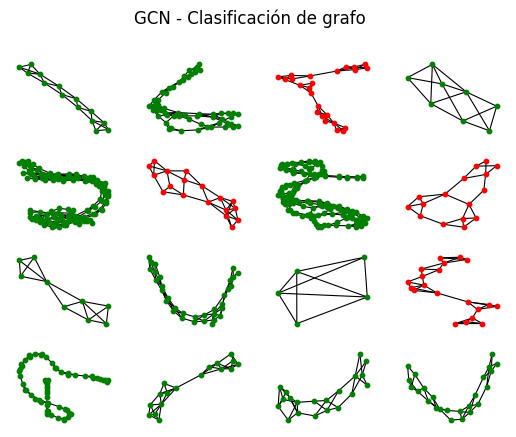

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

fig, ax = plt.subplots(4, 4)
fig.suptitle('GCN - Clasificación de grafo')

for i, data in enumerate(dataset[-16:]):
    # Calcular color (verde si es correcto, rojo si es erróneo)
    out = gcn(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Pintamos el grafo
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=10,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

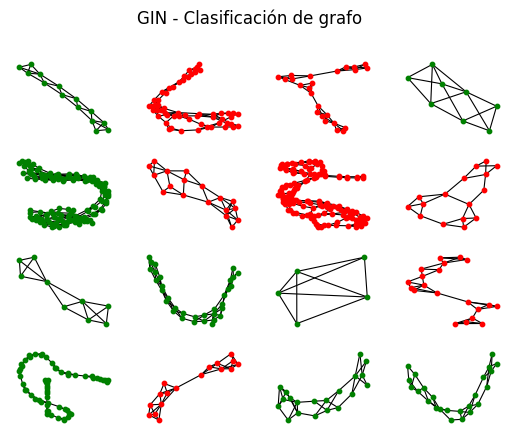

In [8]:
fig, ax = plt.subplots(4, 4)
fig.suptitle('GIN - Clasificación de grafo')

for i, data in enumerate(dataset[-16:]):
    # Calcular color (verde si es correcto, rojo si es erróneo)
    out = gin(data.x, data.edge_index, data.batch)
    color = "green" if out.argmax(dim=1) == data.y else "red"

    # Pintamos el grafo
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=10,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

In [9]:
gcn.eval()
gin.eval()
acc_gcn = 0
acc_gin = 0
acc_ens = 0

for data in test_loader:
    # Traer las clasificaciones
    out_gcn = gcn(data.x, data.edge_index, data.batch)
    out_gin = gin(data.x, data.edge_index, data.batch)
    out_ens = (out_gcn + out_gin)/2

    # Calcular puntuaciones de 'accuracy'
    acc_gcn += accuracy(out_gcn.argmax(dim=1), data.y) / len(test_loader)
    acc_gin += accuracy(out_gin.argmax(dim=1), data.y) / len(test_loader)
    acc_ens += accuracy(out_ens.argmax(dim=1), data.y) / len(test_loader)

# Print results
print(f'GCN accuracy:     {acc_gcn*100:.2f}%')
print(f'GIN accuracy:     {acc_gin*100:.2f}%')
print(f'GCN+GIN accuracy: {acc_ens*100:.2f}%')

GCN accuracy:     68.75%
GIN accuracy:     69.01%
GCN+GIN accuracy: 67.19%
